## Import de la base de donnée et pré-traitement


In [16]:
import pandas as pd
from matplotlib import pyplot as plt
import pandas as pd 
import numpy as np

from src.utility.descriptive_statistics import descriptive_statistics
from src.graph.graph import plot_time_series

df = pd.read_pickle('src/data/panel_data.pkl')
df["index"] = pd.to_datetime(df["index"])

# Filtrage des dates spécifiques (outliers)
outlier_dates = [pd.Timestamp('2001-09-11')]
df = df[~df['index'].isin(outlier_dates)]

df = df[(df['index'] >= '1988-01-01') & (df['index'] <= '2017-01-31')]


for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')
print(df)

          index  Maturity 1  Maturity 2  Maturity 3  Maturity 4  Maturity 5
0    1988-01-04      187.50      193.50      198.25      200.00      202.75
1    1988-01-05      187.50      193.25      197.25      198.25      200.75
2    1988-01-06      191.00      195.75      199.75      201.75      204.50
3    1988-01-07      192.75      198.75      202.75      204.50      208.50
4    1988-01-08      192.50      198.00      202.00      203.50      207.25
...         ...         ...         ...         ...         ...         ...
7308 2017-01-25      366.25      373.50      380.75      387.00      393.75
7309 2017-01-26      363.75      371.00      378.00      384.25      390.75
7310 2017-01-27      362.50      369.75      376.50      383.00      389.25
7311 2017-01-30      357.75      365.00      372.00      378.75      385.50
7312 2017-01-31      359.75      367.00      373.75      380.50      387.25

[7332 rows x 6 columns]


## Statistiques descriptives

In [17]:
original_stats, log_stats = descriptive_statistics(df["Maturity 1"])

stats_keys = ['Mean', 'Median', 'Minimum', 'Maximum', 'Std deviation', 'Skewness', 'Kurtosis', 'Autocorrelation', 'ADF test p-value (10 lags)', 'Nb obs']
df_combined_stats = pd.DataFrame(index=stats_keys, columns=['Prices (c/bu)', 'Log returns'])

for key in stats_keys:
    df_combined_stats.loc[key, 'Prices (c/bu)'] = original_stats.get(key, np.nan)
    log_key = 'Log ' + key  
    df_combined_stats.loc[key, 'Log returns'] = log_stats.get(log_key, np.nan)
    
df_combined_stats

,Prices (c/bu),Log returns
Mean,328.1073,0.0001
Median,269.5,0.0
Minimum,174.75,-0.272
Maximum,831.25,0.128
Std deviation,143.7278,0.0172
Skewness,1.53,-1.04
Kurtosis,1.58,19.62
Autocorrelation,0.999,0.05
ADF test p-value (10 lags),0.16,0.0
Nb obs,7332,7331


## Graphique


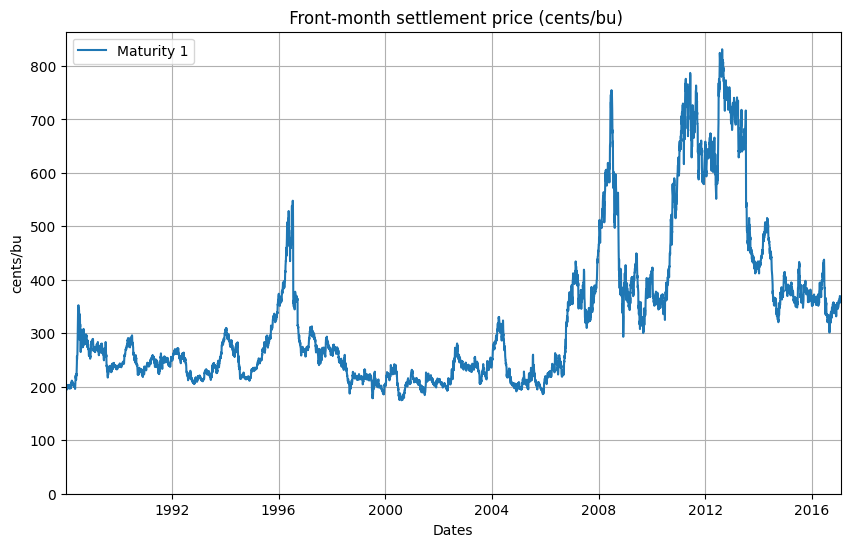

In [18]:
plot_time_series(df,["Maturity 1"],  " Front-month settlement price (cents/bu)", "Dates", "cents/bu")

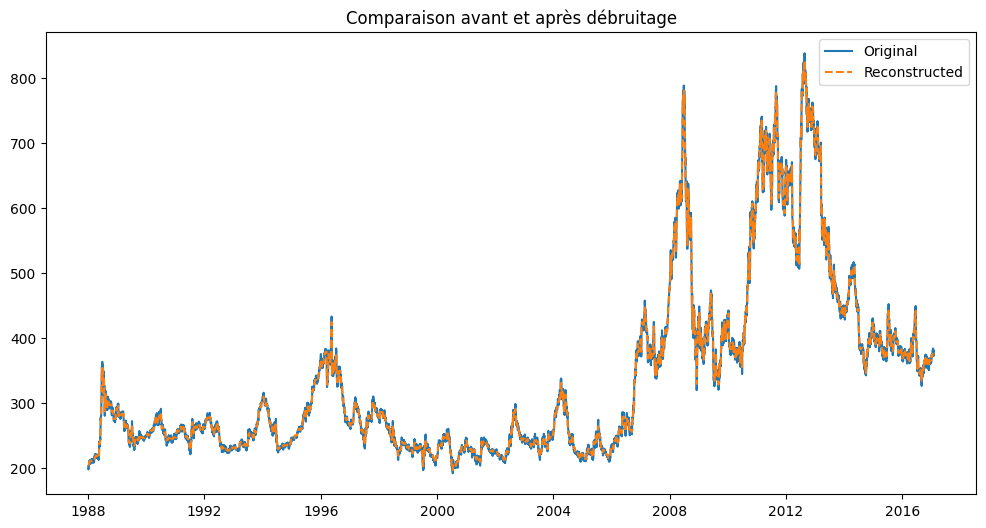

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from src.model import wavelet  # Assurez-vous que wavelet.py est dans le même dossier ou correctement configuré dans le PYTHONPATH

# Charger les données
df = pd.read_pickle('src/data/panel_data.pkl')
df["index"] = pd.to_datetime(df["index"])
df = df[(df['index'] >= '1988-01-01') & (df['index'] <= '2017-01-31')]
data = df['Maturity 3'].dropna()  # Remplacez 'nom_de_la_colonne' par le nom réel de la colonne

# Appliquer la transformation en ondelette
coeffs = wavelet.apply_wavelet_decomposition(data)

# Calculer le seuil basé sur MAD et appliquer le seuillage
threshold = wavelet.calculate_mad_based_threshold(coeffs, len(data))
thresholded_coeffs = wavelet.threshold_coeffs(coeffs, threshold)

# Reconstruction du signal
reconstructed_signal = wavelet.reconstruct_signal_from_coeffs(thresholded_coeffs)

# Ajustement de la longueur si nécessaire et affichage
if len(reconstructed_signal) != len(data):
    reconstructed_signal = reconstructed_signal[:len(data)]

plt.figure(figsize=(12, 6))
plt.plot(df['index'][:len(data)], data, label='Original')
plt.plot(df['index'][:len(data)], reconstructed_signal, label='Reconstructed', linestyle='--')
plt.legend()
plt.title('Comparaison avant et après débruitage')
plt.show()


In [20]:
from src.model.kalman_filter import kalman_filter
from src.model.model import get_state_transition_matrix, get_measurement_matrix, get_process_noise_covariance, get_measurement_constant
from src.utility.constant import DELTA

# Paramètres pour la démonstration
K2, K3, K4 = 0.1, 0.2, 0.3  # Coefficients de réversion moyenne pour chaque facteur
kappa2, kappa3, kappa4 = 0.1, 0.2, 0.3  # Paramètres additionnels pour la covariance
rho12, rho13, rho23, rho14 = 0.5, 0.3, 0.4, 0.2  # Coefficients de corrélation
sigma1, sigma2, sigma3, sigma4 = 0.1, 0.1, 0.1, 0.1  # Volatilités pour les processus de diffusion

# Définition des matrices d'état et de mesure pour un modèle à 3 facteurs
A = get_state_transition_matrix(3, K2, K3, K4)
C = get_measurement_matrix(3, [1, 2, 3, 4, 5], 0, K2, K3, K4)
Q = get_process_noise_covariance(3, kappa2, kappa3, kappa4, rho12, rho13, rho23, rho14, K2, K3, K4, sigma1, sigma2, sigma3, sigma4)
R = np.diag([0.01] * 5)  # Hypothèse d'une petite variance pour le bruit de mesure

# Vecteurs d'interception et constantes de mesure
mu = 0.05
sigma = 0.2
lambdas = {1: 0.1, 2: 0.15, 3: 0.2}
T = [1, 2, 3, 4, 5]  # Maturités pour la mesure

# Fonction cyclique pour la mesure
gamma_cos = {1: 0.1, 2: 0.05}
gamma_sin = {1: 0.1, 2: 0.05}
def s_func(t):
    return sum(gamma_cos[k] * np.cos(2 * np.pi * k * t) + gamma_sin[k] * np.sin(2 * np.pi * k * t) for k in range(1, 3))

ct = get_measurement_constant(3, 0, mu, sigma, lambdas, T, s_func)

# Conditions initiales pour le filtre de Kalman
x0 = np.zeros(3)  # État initial estimé pour 3 facteurs
P0 = np.eye(3)  # Covariance initiale de l'état

# Simuler des observations (log-prix) pour 100 jours pour 5 maturités
Y = np.log(np.random.rand(100, 5) * 100)

# Application du filtre de Kalman
x_est, P_est = kalman_filter(Y, A, C, Q, R, x0, P0)

print("Estimations des états:\n", x_est[-1])  # Affichage des estimations finales des états
print("Covariances estimées:\n", P_est[-1])  # Affichage de la covariance estimée des états


Estimations des états:
 [ 3.74994147  1.23998574 -1.87947764]
Covariances estimées:
 [[ 4.04982282e-04 -3.46575720e-04  9.27675989e-05]
 [-3.46575720e-04  5.23466595e-03 -6.02351370e-03]
 [ 9.27675989e-05 -6.02351370e-03  8.44983114e-03]]


In [21]:
import numpy as np
import pandas as pd

# Charger les données
df = pd.read_pickle('src/data/panel_data.pkl')
df["index"] = pd.to_datetime(df["index"])

# Filtrage des outliers et des dates
outlier_dates = [pd.Timestamp('2001-09-11')]
df = df[~df['index'].isin(outlier_dates)]
df = df[(df['index'] >= '1988-01-01') & (df['index'] <= '2017-01-31')]

# Conversion en log-prix
for col in df.columns[1:]:
    df[col] = np.log(pd.to_numeric(df[col], errors='coerce'))

# Afficher un aperçu des données
print(df.head())

# Assumons des paramètres déjà définis pour la démonstration
num_factors = 1  # Selon le nombre de facteurs que vous souhaitez estimer
K2, K3, K4 = 0.1, 0.2, 0.3
sigma1, sigma2, sigma3, sigma4 = 0.1, 0.1, 0.1, 0.1
rho12, rho13, rho23, rho14 = 0.5, 0.3, 0.4, 0.2

# Matrices de modèle basées sur les fonctions définies
A = get_state_transition_matrix(num_factors, K2, K3, K4)
C = get_measurement_matrix(num_factors, [1, 2, 3, 4, 5], 0, K2, K3, K4)
Q = get_process_noise_covariance(num_factors, 0.1, 0.2, 0.3, 0.5, 0.3, 0.4, 0.2, K2, K3, K4, sigma1, sigma2, sigma3, sigma4)
R = np.diag([0.01] * 5)  # Petite variance pour les erreurs de mesure
x0 = np.zeros(num_factors)  # État initial estimé
P0 = np.eye(num_factors)  # Covariance initiale de l'état

# Log-prix comme observations
Y = df.iloc[:, 1:].values  # Exclure la colonne d'indice

# Exécution du filtre de Kalman
x_est, P_est = kalman_filter(Y, A, C, Q, R, x0, P0)

# Afficher les résultats
print("Estimations finales des états:\n", x_est[-1])
print("Covariances estimées finales:\n", P_est[-1])



       index  Maturity 1  Maturity 2  Maturity 3  Maturity 4  Maturity 5
0 1988-01-04    5.233779    5.265278    5.289529    5.298317    5.311974
1 1988-01-05    5.233779    5.263985    5.284472    5.289529    5.302060
2 1988-01-06    5.252273    5.276838    5.297067    5.307029    5.320568
3 1988-01-07    5.261394    5.292048    5.311974    5.320568    5.339939
4 1988-01-08    5.260096    5.288267    5.308268    5.315666    5.333926
Estimations finales des états:
 [5.92805384]
Covariances estimées finales:
 [[0.00026355]]
